In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from variables import variable_names

# Define the list of cities
cities_list = ["Boston", "Chicago", "Dallas", "Houston", "Los Angeles", "Miami", "New York", "Oakland", "Philadelphia", "Washington"]

# Create an empty DataFrame to store the combined data for all cities
all_city_data = pd.DataFrame()

# Loop through the cities and load the data for each city
for city in cities_list:
    # Load the data for the current city
    city_data = pd.read_csv(f"airbnb_{city}.csv")
    
    # Add a 'City' column to identify the city for each row
    city_data['City'] = city
    
    # Concatenate the current city's data with the combined data
    all_city_data = pd.concat([all_city_data, city_data])

# Now you have a DataFrame 'all_city_data' containing data for all cities
# You can perform citywise analysis on this combined data
# Selecting columns as per the dataset description and additional columns
extra_columns = [
    'hostResponseNumber_pastYear',
    'hostResponseAverage_pastYear',
    'prev_hostResponseNumber_pastYear',
    'prev_hostResponseAverage_pastYear'
]

required_columns = variable_names + extra_columns + ["City"]

# Ensuring only the required columns are in the DataFrame
data = all_city_data[required_columns]

print(len(data))
print(f"column length = {len(data.columns)}")


C:\Users\Owner\AppData\Local\Temp\ipykernel_29532\3703566966.py:15: DtypeWarning: Columns (59) have mixed types. Specify dtype option on import or set low_memory=False.
  city_data = pd.read_csv(f"airbnb_{city}.csv")


2075367
column length = 100


In [2]:
ignorable_columns = ["City_x", "Scraped Date", "Superhost", "prev_host_is_superhost"]

race_columns = ["tract_white_perc", "tract_black_perc", "tract_asian_perc", "zip_hispanic_or_latino_anyrace", "zip_hispanic_or_latino_anyrace_percent", "zip_white_nothispanic", "zip_white_nothispanic_percent", "zip_black_nothispanic", "zip_black_nothispanic_percent", "zip_asian_nothispanic", "zip_asian_nothispanic_percent"]

columns_to_remove = ignorable_columns + race_columns

# Drop the specified columns from the DataFrame
data.drop(columns=columns_to_remove, inplace=True)

print(len(data))
print(f"new column length = {len(data.columns)}")

data_size = len(data)


2075367
new column length = 85


C:\Users\Owner\AppData\Local\Temp\ipykernel_29532\4278650091.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=columns_to_remove, inplace=True)


In [3]:
# Checking the percentage of missing values in each column
missing_values = data.isnull().mean() * 100

# Displaying columns with missing values and their percentage
missing_values[missing_values > 0].sort_values(ascending=False)


prev_revenue                                        47.489817
prev_booked_days_avePrice                           47.489817
prev_occupancy_rate                                 47.489769
prev_booked_days                                    47.489721
booked_days_avePrice                                45.741934
revenue                                             45.741934
occupancy_rate                                      45.741886
booked_days                                         45.741837
prev_rating_ave_pastYear                            35.857032
prev_prop_5_StarReviews_pastYear                    35.857032
prev_numReviews_pastYear                            34.669290
prev_numCancel_pastYear                             34.669290
prev_num_5_star_Rev_pastYear                        34.669290
rating_ave_pastYear                                 30.241013
prop_5_StarReviews_pastYear                         30.241013
num_5_star_Rev_pastYear                             28.940424
numCance

Check this preprocessing step. Not the ideal case right now.

In [4]:
# Addressing missing values and data preprocessing

# Skip this part

# 1. Dropping columns with very high percentage of missing values (e.g., >50%)
columns_to_drop = missing_values[missing_values > 50].index
airbnb_data_cleaned = data.drop(columns=columns_to_drop)

# 2. Imputing missing values for other columns
# For simplicity, I will use median imputation for numeric columns and mode imputation for categorical columns
numeric_cols = airbnb_data_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = airbnb_data_cleaned.select_dtypes(include=['object']).columns

# Imputing numeric columns with median
for col in numeric_cols:
    airbnb_data_cleaned[col].fillna(airbnb_data_cleaned[col].median(), inplace=True)

# Imputing categorical columns with mode
for col in categorical_cols:
    airbnb_data_cleaned[col].fillna(airbnb_data_cleaned[col].mode()[0], inplace=True)

# 3. Outlier detection and handling will be done during EDA as it often requires specific analysis per column.

# Checking the dataset after preprocessing
airbnb_data_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2075367 entries, 0 to 133740
Data columns (total 85 columns):
 #   Column                                            Dtype  
---  ------                                            -----  
 0   Airbnb Host ID                                    float64
 1   Airbnb Property ID                                float64
 2   superhost_period_all                              float64
 3   host_is_superhost_in_period                       float64
 4   prev_host_is_superhost_in_period                  float64
 5   superhost_change                                  float64
 6   superhost_change_lose_superhost                   float64
 7   superhost_change_gain_superhost                   float64
 8   rating_ave_pastYear                               float64
 9   numReviews_pastYear                               float64
 10  numCancel_pastYear                                float64
 11  num_5_star_Rev_pastYear                           float64
 12  prop_5

Plain Optimisation

In [5]:
from sklearn.preprocessing import MinMaxScaler

airbnb_data_cleaned['booking_rate'] = (airbnb_data_cleaned['booked_days'] / airbnb_data_cleaned['available_days']) * 100
airbnb_data_cleaned['tract_hosts'] = (airbnb_data_cleaned['tract_superhosts'] / airbnb_data_cleaned['tract_superhosts_ratio']) * 100

# Remove rows where available_days or tract_superhosts_ratio is 0
airbnb_data_cleaned = airbnb_data_cleaned[(airbnb_data_cleaned['available_days'] != 0) & (airbnb_data_cleaned['tract_superhosts_ratio'] != 0)]


# Calculating normalized metrics for bookings and cancellations per population on a city level
city_metrics = airbnb_data_cleaned.groupby('City').agg({
    'numReservedDays_pastYear': 'sum',
    'numCancel_pastYear': 'sum',
    'tract_housing_units' : 'sum',
    'revenue' : 'sum',
    'tract_superhosts' : 'sum',
    'tract_hosts':'sum',
    'booking_rate':'mean',
    'tract_total_pop': 'mean'
}).reset_index()


# filtering
city_metrics = city_metrics[city_metrics['tract_hosts'] != 0]


city_metrics['booking_rate_per_host'] = city_metrics['booking_rate'] / city_metrics['tract_hosts']
city_metrics['booking_rate_per_housing_unit'] = city_metrics['booking_rate'] / city_metrics['tract_housing_units']

city_metrics['revenue_per_host'] = city_metrics['revenue'] / city_metrics['tract_hosts']
city_metrics['revenue_per_housing_unit'] = city_metrics['revenue'] / city_metrics['tract_housing_units']

city_metrics['superhosts_per_host'] = city_metrics['tract_superhosts'] / city_metrics['tract_hosts']
city_metrics['superhosts_per_housing_unit'] = city_metrics['tract_superhosts'] / city_metrics['tract_housing_units']

city_metrics['cancellations_per_host'] = city_metrics['numCancel_pastYear'] / city_metrics['tract_hosts']
city_metrics['cancellations_per_housing_unit'] = city_metrics['numCancel_pastYear'] / city_metrics['tract_housing_units']

city_metrics['reservations_per_host'] = city_metrics['numReservedDays_pastYear'] / city_metrics['tract_hosts']
city_metrics['reservations_per_housing_unit'] = city_metrics['numReservedDays_pastYear'] / city_metrics['tract_housing_units']


############################

# Select the columns you want to normalize
columns_to_normalize = [
    'booking_rate_per_host',
    'revenue_per_host',
    'superhosts_per_host',
    'reservations_per_host',
    'cancellations_per_host',
    'booking_rate_per_housing_unit',
    'revenue_per_housing_unit',
    'superhosts_per_housing_unit',
    'reservations_per_housing_unit',
    'cancellations_per_housing_unit'
]


column_name_mapping = {
    'booking_rate_per_host': 'booking_rate_per_housing_unit',
    'revenue_per_host': 'revenue_per_housing_unit',
    'superhosts_per_host': 'superhosts_per_housing_unit',
    'reservations_per_host': 'reservations_per_housing_unit',
    'cancellations_per_host': 'cancellations_per_housing_unit'
}

# Create a MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100))

# Apply Min-Max scaling to the selected columns
city_metrics[columns_to_normalize] = scaler.fit_transform(city_metrics[columns_to_normalize])

In [6]:
# Combined score per host
city_metrics['combined_score_per_host'] = (
    city_metrics['booking_rate_per_host'] +
    city_metrics['revenue_per_host'] +
    city_metrics['superhosts_per_host'] +
    city_metrics['reservations_per_host'] -
    city_metrics['cancellations_per_host']
)



final_per_host = city_metrics.sort_values(by='combined_score_per_host', ascending=False)
final_per_host[["City", "combined_score_per_host"]]

,City,combined_score_per_host
7,Oakland,241.477518
1,Chicago,230.376751
2,Dallas,168.390218
9,Washington,75.956511
0,Boston,73.689445
3,Houston,66.607554
8,Philadelphia,65.699838
4,Los Angeles,39.032313
6,New York,21.995084
5,Miami,-17.080418


In [33]:
final_per_housing_unit = city_metrics.sort_values(by='combined_score_per_housing_unit', ascending=False)
final_per_housing_unit[["City", "combined_score_per_housing_unit"]]

,City,combined_score_per_housing_unit
7,Oakland,170.930990
2,Dallas,158.190530
0,Boston,152.653195
9,Washington,131.356415
4,Los Angeles,130.892158
8,Philadelphia,100.348072
5,Miami,65.899906
1,Chicago,62.508447
3,Houston,33.366250
6,New York,28.459934


10


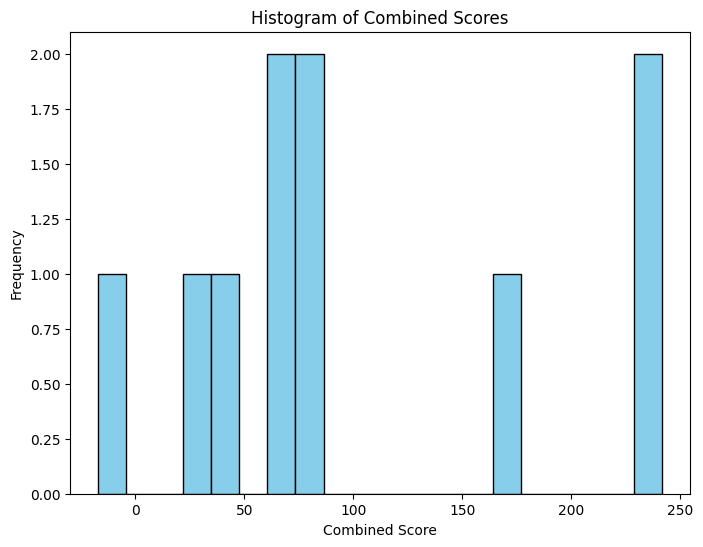

In [ ]:
import matplotlib.pyplot as plt

# Group by census tract and calculate the sum of combined scores
city_scores = city_metrics.groupby('City')['combined_score_per_host'].sum()

# Sort the tract scores in descending order
sorted_tract_scores = city_scores.sort_values(ascending=False)

print(len(city_scores))
plt.style.use('ggplot')

# Create a histogram of the combined scores
plt.figure(figsize=(8, 6))
plt.hist(city_metrics['combined_score_per_host'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Combined Score')
plt.ylabel('Frequency')
plt.title('Histogram of Combined Scores')
plt.show()

# sorted_tract_scores